In [352]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [ ]:
def Scrape(start_page,end_page,file_name): #End page is not inclusive
    names,addresses,beds,baths,year_built,tenure,property_type,mrt,price,sqft = [],[],[],[],[],[],[],[],[],[]
    housing = ['HDB','HDB 2 Rooms','HDB 3 Rooms','HDB 4 Rooms','HDB 5 Rooms','HDB Executive','Condo','Apartment','Walk-up','Landed','Executive Condo','Terraced House','Corner Terrace','Semi-Detached','Bungalow','Good Class Bungalow','Cluster House']
    chrome_options = webdriver.ChromeOptions()
    for num in range(start_page,end_page):
        driver = webdriver.Chrome("chromedriver.exe")
        driver.implicitly_wait(5)
        driver.get('https://www.99.co/singapore/sale?page_num={}'.format(num))
        time.sleep(3)
        links =[]

        soup=BeautifulSoup(driver.page_source, 'lxml')
        for link in soup.find_all('a'):
            if type(link.get('href'))==str and 'Search' in link.get('href') and 'page_num'not in link.get('href'):

                links.append('https://www.99.co'+link.get('href'))


        for c,i in enumerate(links): 

            driver.get(i)
            time.sleep(1.5)
            soup=BeautifulSoup(driver.page_source, 'lxml')
            name = soup.find('h1', attrs={'class': '_3Wogd JMF8h lFqTi _1vzK2'})
            names.append(name.getText())


            address = soup.find_all('p', attrs={'class': 'dniCg _3j72o _2rhE-'})
            a = []
            for i in address:
                a.append(i.getText())
            addresses.append(re.findall('(\(D\d\d\)|\(D\d\))',''.join(a)))

            bed = soup.find_all('p', attrs={'class': '_2sIc2 _29qfj _2rhE-'})
            temp1 = ['NA','NA','NA']
            for i in bed:
                if 'Bed'in i.getText().split() or 'Beds' in i.getText().split():
                    temp1[0]=i.getText().split()[0]

                elif 'Bath' in i.getText().split() or 'Baths' in i.getText().split():
                    temp1[1]=i.getText().split()[0]

                elif 'sqft' in i.getText().split():
                    temp1[2]=i.getText().split()[0]
                elif 'Studio' in i.getText().split():
                    temp1[0]=i.getText()            
                else:
                    print('Please maunually get info for page{} and link with index {}'.format(num,c))

            beds.append(temp1[0])
            baths.append(temp1[1])
            sqft.append(temp1[2])


            info = soup.find_all('div', attrs={'class': '_3r4yN XCAFU'})
            temp = ['NA','NA','NA']

            for i in info:
                if 'year' in i.getText().lower():
                    temp[0]=i.getText()[:2]
                elif 'Freehold' in i.getText():
                    temp[0]=i.getText()
                elif re.findall('\d\d\d\d',i.getText())!=[]:
                    temp[1]=i.getText()
                elif i.getText() in housing:
                    temp[2]=i.getText()   
            tenure.append(temp[0])
            year_built.append(temp[1])
            property_type.append(temp[2])

            mrts = soup.find_all('p', attrs={'class': '_2sIc2 _2rhE- _1c-pJ'})
            temp2 = ['NA']
            for i in mrts:
                if re.findall('\(\d+ m\)',''.join(i.getText()))!=[]:
                        temp2[0]=re.findall('\(\d+ m\)',''.join(i.getText()))
            mrt.append(temp2[0])



            prices = soup.find('h2', attrs={'class': '_1zGm8 _3na6W _1vzK2'})
            price.append(prices.getText()[1:])

        if len(names)==len(addresses) and len(addresses)==len(beds) and len(beds)==len(baths) and len(baths)==len(year_built) and len(year_built)==len(tenure) and len(tenure)==len(property_type) and len(property_type)==len(mrt) and len(mrt)==len(price):
            print('All good for page number {}!'.format(num))
        else:
            print('shit, houston we have a problem!')
            break
        driver.close()
    data=pd.DataFrame(names,columns=['title'])
    data['address_code']=addresses
    data['beds']=beds
    data['baths']=baths
    data['year_built']=year_built
    data['tenure']=tenure
    data['property_type']=property_type
    data['mrt_distance']=mrt
    data['sqft']=sqft
    data['price']=price
    data.to_csv(file_name)
    print('Scraped Successfully! :)')

In [93]:
data_list = []
c=1
for i in range(17):
    data_list.append(pd.read_csv('scraped_pg{}_pg{}.csv'.format(c,c+9)))
    c+=10
data = pd.concat(data_list)
data.head()

,Unnamed: 0,title,address_code,beds,baths,year_built,tenure,property_type,mrt_distance,sqft,price
0,0,HDB Flat for Sale in 110A Depot Road,['(D4)'],3,3.0,NaN,99,HDB,NaN,990,"730,000"
1,1,HDB Flat for Sale in 208B Clementi Avenue 6,['(D5)'],2,2.0,NaN,NaN,HDB 3 Rooms,['(906 m)'],731,"610,000"
2,2,HDB Flat for Sale in 560 Hougang Street 51,['(D19)'],4,2.0,1999,99,HDB,['(438 m)'],"1,539","768,000"
3,3,HDB Flat for Sale in 322C Anchorvale Drive,['(D19)'],3,2.0,2002,99,HDB,['(369 m)'],"1,184","558,888"
4,4,HDB Flat for Sale in 225 Ang Mo Kio Avenue 1,['(D20)'],2,2.0,1978,NaN,HDB 3 Rooms,NaN,882,"375,000"


In [94]:
data1 = pd.read_csv('scraped_pg171_pg200.csv')
data2 = pd.read_csv('scraped_pg201_pg228.csv')
data_final = pd.concat([data,data1,data2])
data_final

,Unnamed: 0,title,address_code,beds,baths,year_built,tenure,property_type,mrt_distance,sqft,price
0,0,HDB Flat for Sale in 110A Depot Road,['(D4)'],3,3.0,NaN,99,HDB,NaN,990,"730,000"
1,1,HDB Flat for Sale in 208B Clementi Avenue 6,['(D5)'],2,2.0,NaN,NaN,HDB 3 Rooms,['(906 m)'],731,"610,000"
2,2,HDB Flat for Sale in 560 Hougang Street 51,['(D19)'],4,2.0,1999,99,HDB,['(438 m)'],"1,539","768,000"
3,3,HDB Flat for Sale in 322C Anchorvale Drive,['(D19)'],3,2.0,2002,99,HDB,['(369 m)'],"1,184","558,888"
4,4,HDB Flat for Sale in 225 Ang Mo Kio Avenue 1,['(D20)'],2,2.0,1978,NaN,HDB 3 Rooms,NaN,882,"375,000"
...,...,...,...,...,...,...,...,...,...,...,...
975,975,2 Bed Condo for Sale in Whitehaven,['(D5)'],2,2.0,2017,Freehold,Apartment,['(2460 m)'],538,"960,000"
976,976,3 Bed House for Sale in Sennett Estate,['(D13)'],3,2.0,NaN,Freehold,Corner Terrace,['(548 m)'],"3,179","4,500,000"
977,977,3 Bed EC for Sale in Citylife @ Tampines,['(D18)'],3,3.0,2016,99,Executive Condo,['(1128 m)'],"1,216","1,350,000"
978,978,5 Bed Condo for Sale in Hillion Residences,['(D23)'],5,3.0,2018,99,Condo,['(58 m)'],"2,616","3,029,000"


In [95]:
data_final.drop('Unnamed: 0',axis=1,inplace=True)

In [96]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          7980 non-null   object 
 1   address_code   7980 non-null   object 
 2   beds           7974 non-null   object 
 3   baths          7414 non-null   float64
 4   year_built     7385 non-null   object 
 5   tenure         7475 non-null   object 
 6   property_type  7751 non-null   object 
 7   mrt_distance   6027 non-null   object 
 8   sqft           7980 non-null   object 
 9   price          7980 non-null   object 
dtypes: float64(1), object(9)
memory usage: 685.8+ KB


In [97]:
data_final.to_csv('compiled_data.csv')

In [186]:
data_final = pd.read_csv('compiled_data.csv',index_col=0)

<AxesSubplot:>

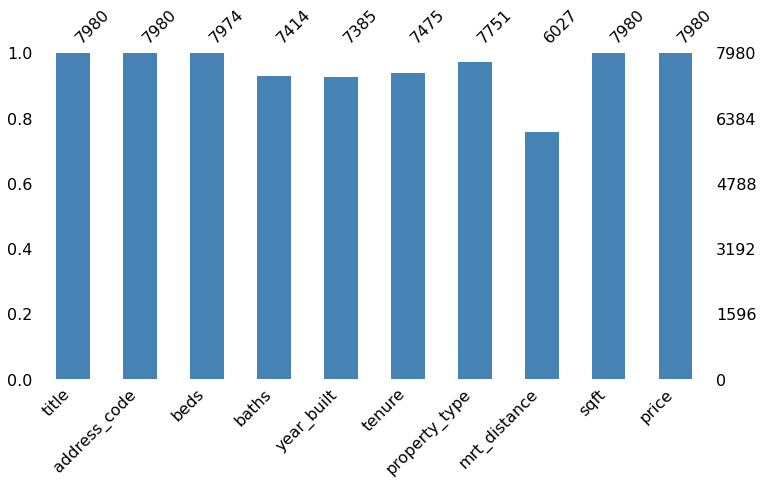

In [135]:
msno.bar(data_final, figsize=(12,6),color='steelblue')

In [187]:
data_final=data_final.drop_duplicates()

In [137]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6130 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          6130 non-null   object 
 1   address_code   6130 non-null   object 
 2   beds           6124 non-null   object 
 3   baths          5660 non-null   float64
 4   year_built     5715 non-null   object 
 5   tenure         5732 non-null   object 
 6   property_type  5961 non-null   object 
 7   mrt_distance   4652 non-null   object 
 8   sqft           6130 non-null   object 
 9   price          6130 non-null   object 
dtypes: float64(1), object(9)
memory usage: 526.8+ KB


In [138]:
data_final['address_code'].value_counts()

['(D19)']    805
['(D10)']    495
['(D15)']    441
['(D18)']    393
['(D5)']     388
['(D9)']     388
['(D3)']     354
['(D14)']    280
['(D23)']    252
['(D4)']     236
['(D16)']    194
['(D11)']    186
['(D12)']    169
['(D27)']    168
['(D2)']     159
['(D28)']    155
['(D1)']     153
['(D21)']    144
['(D13)']    142
['(D20)']    135
['(D22)']    109
['(D7)']     108
['(D17)']     94
['(D8)']      89
['(D25)']     68
['(D26)']     23
['(D6)']       2
Name: address_code, dtype: int64

In [188]:
data_final['address_code']=data_final['address_code'].apply(lambda x: re.findall('D\d+',x)[0])

In [145]:
data_final['address_code'].value_counts()

D19    805
D10    495
D15    441
D18    393
D5     388
D9     388
D3     354
D14    280
D23    252
D4     236
D16    194
D11    186
D12    169
D27    168
D2     159
D28    155
D1     153
D21    144
D13    142
D20    135
D22    109
D7     108
D17     94
D8      89
D25     68
D26     23
D6       2
Name: address_code, dtype: int64

In [161]:
data_final['beds'].value_counts()

3     2119
2     1653
1      905
4      867
5      360
6       98
0       78
7       23
9        9
8        7
10       5
Name: beds, dtype: int64

In [189]:
data_final.dropna(subset=['beds'],inplace=True)

In [190]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6124 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          6124 non-null   object 
 1   address_code   6124 non-null   object 
 2   beds           6124 non-null   object 
 3   baths          5654 non-null   float64
 4   year_built     5709 non-null   object 
 5   tenure         5726 non-null   object 
 6   property_type  5955 non-null   object 
 7   mrt_distance   4646 non-null   object 
 8   sqft           6124 non-null   object 
 9   price          6124 non-null   object 
dtypes: float64(1), object(9)
memory usage: 526.3+ KB


The defining difference between a studio and 1-bedroom apartment is that a 1-bedroom features a separate bedroom area that is distinct and closed off from the living room and kitchen area. The column beds represents the bedrooms on the website, since studio isn't a separate bedroom, I will change all labelled 'studio' to 0.

In [191]:

data_final['beds']=data_final['beds'].apply(lambda x:0 if x=='Studio' else int(x))

In [178]:
data_final['beds'].value_counts()

3     2119
2     1653
1      905
4      867
5      360
6       98
0       78
7       23
9        9
8        7
10       5
Name: beds, dtype: int64

In [202]:
data_final['baths']=data_final['baths'].apply(lambda x:0 if math.isnan(x) else int(x))

In [208]:
data_final['tenure'].value_counts()

99          3994
Freehold    1683
10            35
95             5
94             4
11             4
60             1
Name: tenure, dtype: int64

In [212]:
data_final[data_final['tenure'].isnull()]

,title,address_code,beds,baths,year_built,tenure,property_type,mrt_distance,sqft,price
1,HDB Flat for Sale in 208B Clementi Avenue 6,D5,2,2,NaN,NaN,HDB 3 Rooms,['(906 m)'],731,"610,000"
4,HDB Flat for Sale in 225 Ang Mo Kio Avenue 1,D20,2,2,1978.0,NaN,HDB 3 Rooms,NaN,882,"375,000"
65,5 Bed House for Sale in Barker Road,D11,5,6,NaN,NaN,Landed,NaN,"2,561","8,100,000"
89,6 Bed House for Sale in Tampines Road,D19,6,7,NaN,NaN,NaN,NaN,"3,074","4,688,888"
90,HDB Flat for Sale in 310B Punggol Walk,D19,3,2,NaN,NaN,HDB 5 Rooms,['(268 m)'],"1,205","680,000"
...,...,...,...,...,...,...,...,...,...,...
895,10 Bed House for Sale in Fortuna Seaview Villas,D16,10,8,NaN,NaN,NaN,['(1053 m)'],"10,000","5,900,000"
906,HDB Flat for Sale in 538 Upper Cross Street,D1,2,2,1978.0,NaN,HDB 2 Rooms,['(277 m)'],732,"555,000"
927,5 Bed House for Sale in Jalan Segam,D16,5,5,NaN,NaN,NaN,NaN,"5,100","4,200,000"
954,HDB Flat for Sale in 172B Edgedale Plains,D19,3,2,2004.0,NaN,HDB,['(254 m)'],"1,184","499,888"


In [217]:
data_final['tenure'].isnull().value_counts()

False    5726
True      398
Name: tenure, dtype: int64

In [222]:
data_final['tenure'].fillna('others',inplace=True)

In [226]:
data_final.dropna(subset=['property_type'],inplace=True)

In [252]:
def mrt_clean(x):
    if re.findall('\d+',str(x))!=[]:
        return float((re.findall('\d+',str(x))[0]))
    else:
        return None

data_final['mrt_distance']=data_final['mrt_distance'].apply(mrt_clean)

In [264]:
mean_value=data_final[data_final['mrt_distance'].notnull()]['mrt_distance'].sort_values(ascending=False).head(45).mean()
data_final[data_final['mrt_distance'].notnull()]['mrt_distance'].sort_values(ascending=False).head(45)

141     5169.0
61      5169.0
872     4388.0
260     4388.0
20      4388.0
23      4388.0
269     4388.0
247     4388.0
893     4388.0
340     4388.0
126     4388.0
1014    4388.0
18      4388.0
96      4388.0
7       4388.0
126     4388.0
342     4388.0
731     4388.0
748     4388.0
143     4388.0
16      4388.0
618     4384.0
439     4352.0
152     3810.0
249     3725.0
69      3725.0
959     3725.0
393     3725.0
125     3645.0
322     3612.0
375     3441.0
305     3441.0
84      3418.0
83      3418.0
290     3418.0
289     3418.0
687     3408.0
204     3408.0
345     3242.0
65      3242.0
310     3242.0
290     3238.0
658     3238.0
57      3238.0
340     3238.0
Name: mrt_distance, dtype: float64

In [268]:
data_final['mrt_distance']=data_final['mrt_distance'].apply(lambda x:mean_value if math.isnan(x)else x)

In [269]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5955 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5955 non-null   object 
 1   address_code   5955 non-null   object 
 2   beds           5955 non-null   int64  
 3   baths          5955 non-null   int64  
 4   year_built     5630 non-null   object 
 5   tenure         5955 non-null   object 
 6   property_type  5955 non-null   object 
 7   mrt_distance   5955 non-null   float64
 8   sqft           5955 non-null   object 
 9   price          5955 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 671.8+ KB


In [273]:
data['sqft']=data['sqft'].apply(lambda x: float(x.replace(',','')))

In [281]:
data_final[data_final['price']=='o be confirmed']

,title,address_code,beds,baths,year_built,tenure,property_type,mrt_distance,sqft,price
116,2 Bed Condo for Sale in Penrose,D14,2,1,2024.0,99,Apartment,452.0,646,o be confirmed
117,3 Bed Condo for Sale in Penrose,D14,3,2,2024.0,99,Apartment,452.0,980,o be confirmed
118,2 Bed Condo for Sale in Forett @ Bukit Timah,D21,2,1,2023.0,Freehold,Apartment,915.0,549,o be confirmed
119,4 Bed Condo for Sale in Penrose,D14,4,3,2024.0,99,Apartment,452.0,"1,389",o be confirmed
117,3 Bed Condo for Sale in Canninghill Piers / Ca...,D17,3,2,2024,99,Condo,417.0,"1,087",o be confirmed
118,1 Bed Condo for Sale in Normanton Park,D5,1,0,1862,99,Condo,3965.8,527,o be confirmed
416,3 Bed Condo for Sale in The Reef At King's Dock,D4,3,3,2025,99,Condo,353.0,"1,216",o be confirmed
824,3 Bed Condo for Sale in Treasure at Tampines,D18,3,0,2023.0,99,Condo,924.0,915,o be confirmed


In [282]:
def price_cleaner(x):
    if x=='o be confirmed':
        return None
    else:
        return float(x.replace(',',''))
    
data_final['price']=data_final['price'].apply(price_cleaner)

In [283]:
data_final.dropna(subset=['price'],inplace=True)

In [284]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5947 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5947 non-null   object 
 1   address_code   5947 non-null   object 
 2   beds           5947 non-null   int64  
 3   baths          5947 non-null   int64  
 4   year_built     5622 non-null   object 
 5   tenure         5947 non-null   object 
 6   property_type  5947 non-null   object 
 7   mrt_distance   5947 non-null   float64
 8   sqft           5947 non-null   object 
 9   price          5947 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 511.1+ KB


The year column contains some non digit strings inside, so I will clean it to 4 digits and use feature engineering to fill the NaN values.

In [300]:
def year_cleaner(x):
    try:
        return int(re.findall('\d\d\d\d',x)[0])
    except:
        return x

data_final['year_built']=data_final['year_built'].apply(year_cleaner)

In [328]:
living = data_final.groupby('address_code')['year_built'].mean()

In [344]:
living

address_code
D1     2012.794702
D10    2011.648712
D11    2013.705128
D12    2009.407407
D13    2018.348837
D14    2014.968254
D15    2012.313625
D16    2003.932203
D17    2012.750000
D18    2011.856410
D19    2014.802153
D2     2013.421384
D20    2003.629921
D21    2011.880435
D22    2005.638889
D23    2011.831897
D25    2010.666667
D26    2009.000000
D27    2007.844720
D28    2016.456000
D3     2012.060519
D4     2011.229358
D5     1975.790576
D6     2015.000000
D7     2015.365385
D8     2011.482759
D9     2015.271642
Name: year_built, dtype: float64

In [343]:
for c,i in enumerate(data_final['year_built']):
    if math.isnan(i):
        living_id=data_final['address_code'].iloc[c]
        data_final['year_built'].iloc[c]=living[living_id]
    

C:\Users\kchun\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [345]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5947 entries, 0 to 979
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          5947 non-null   object 
 1   address_code   5947 non-null   object 
 2   beds           5947 non-null   int64  
 3   baths          5947 non-null   int64  
 4   year_built     5947 non-null   float64
 5   tenure         5947 non-null   object 
 6   property_type  5947 non-null   object 
 7   mrt_distance   5947 non-null   float64
 8   sqft           5947 non-null   object 
 9   price          5947 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 671.1+ KB


In [351]:
data_final.corr()

,beds,baths,year_built,mrt_distance,price
beds,1.000000,0.707449,-0.041064,0.179199,0.452976
baths,0.707449,1.000000,-0.030159,0.155371,0.463805
year_built,-0.041064,-0.030159,1.000000,-0.199265,0.027726
mrt_distance,0.179199,0.155371,-0.199265,1.000000,0.116379
price,0.452976,0.463805,0.027726,0.116379,1.000000


Number of bedrooms seem to be highly correlated to number of baths which makes sense as there is is unlikely to have 5 bedrooms with only 1 bath, hence people desire an equal number in their homes. 

Bedrooms and baths also seem to be the most correlated to price of the porperty.

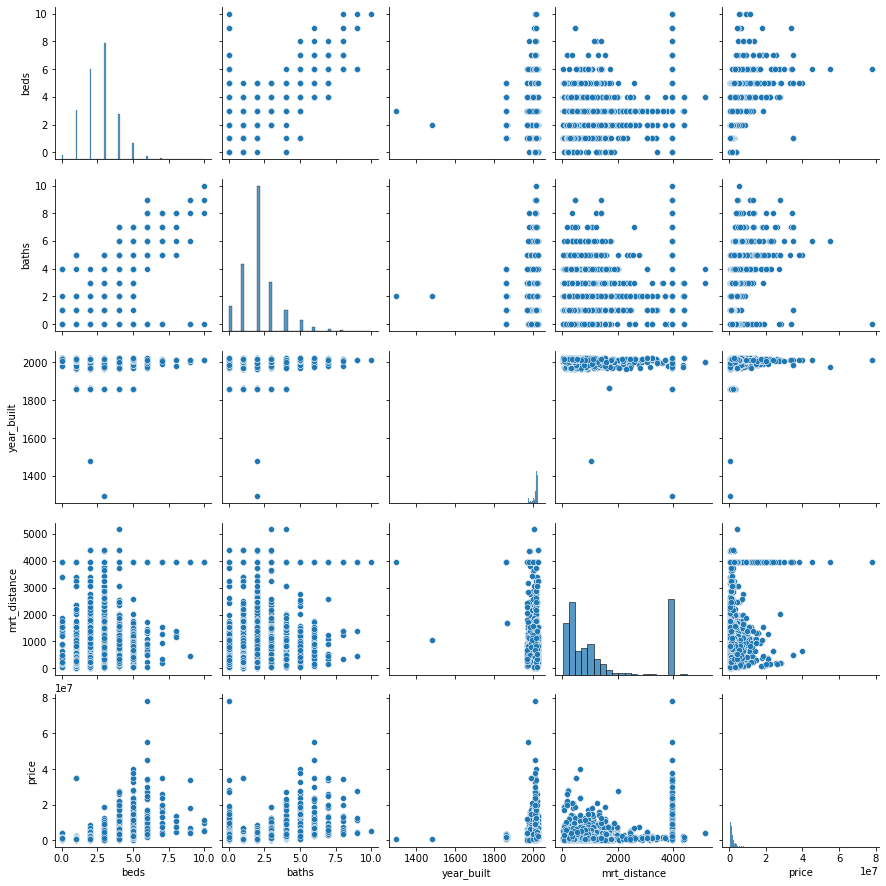

In [353]:
sns.pairplot(data_final)